# Importing Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# Import Data

In [2]:
import pandas as pd
data = pd.read_csv('hmnist_28_28_RGB.csv')

In [3]:
y = data['label']
x = data.drop(columns = ['label'])

# Exploratory Data Analysis (EDA)

In [5]:
tabular_data = pd.read_csv('HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

Frequency Distribution of Classes


Text(0.5, 1.0, 'Frequency Distribution of Classes')

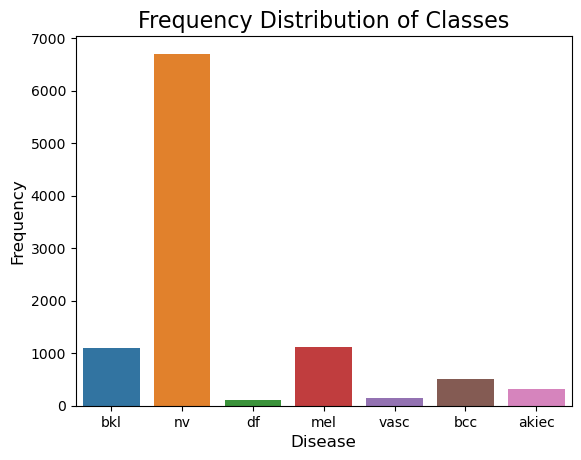

In [30]:
print("Frequency Distribution of Classes")
"""Frequency Distribution of Classes"""

sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Distribution of Disease over Gender


Text(0.5, 1.0, 'Gender of Patient')

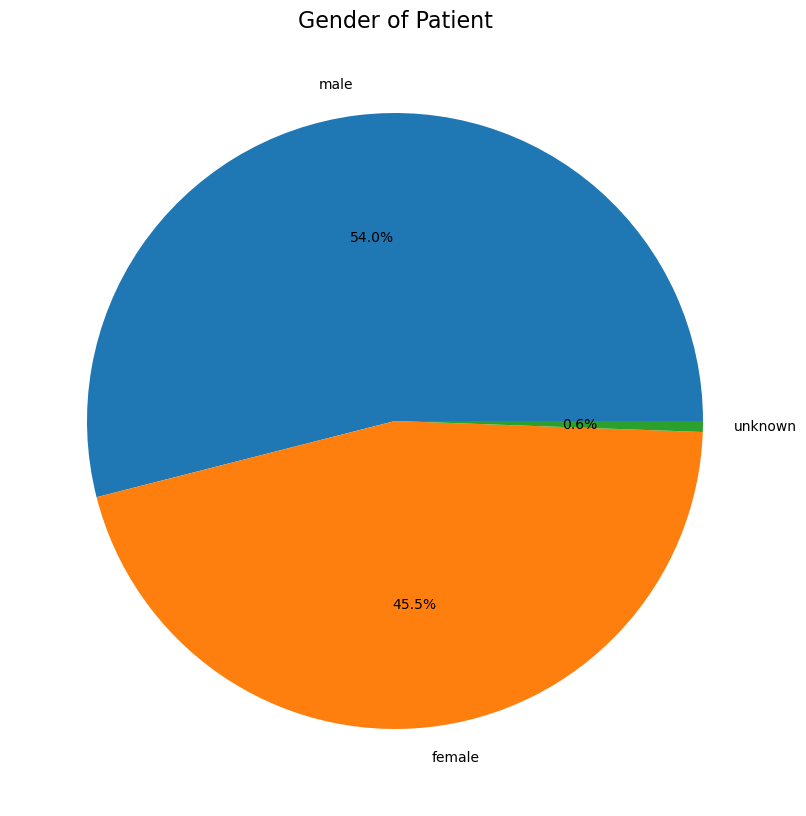

In [29]:
print("Distribution of Disease over Gender")
"""Distribution of Disease over Gender"""

bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Histogram of Age of Patients



Text(0.5, 1.0, 'Histogram of Age of Patients')

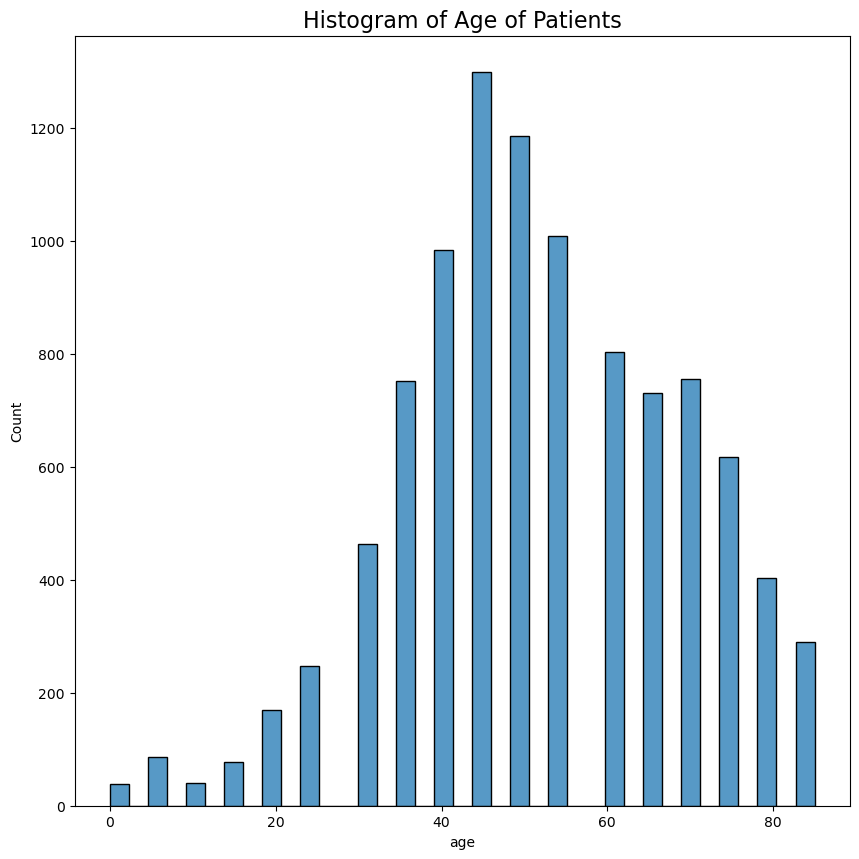

In [16]:
print('Histogram of Age of Patients\n')
bar, ax = plt.subplots(figsize=(10,10)) 
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

Location of disease over Gender


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

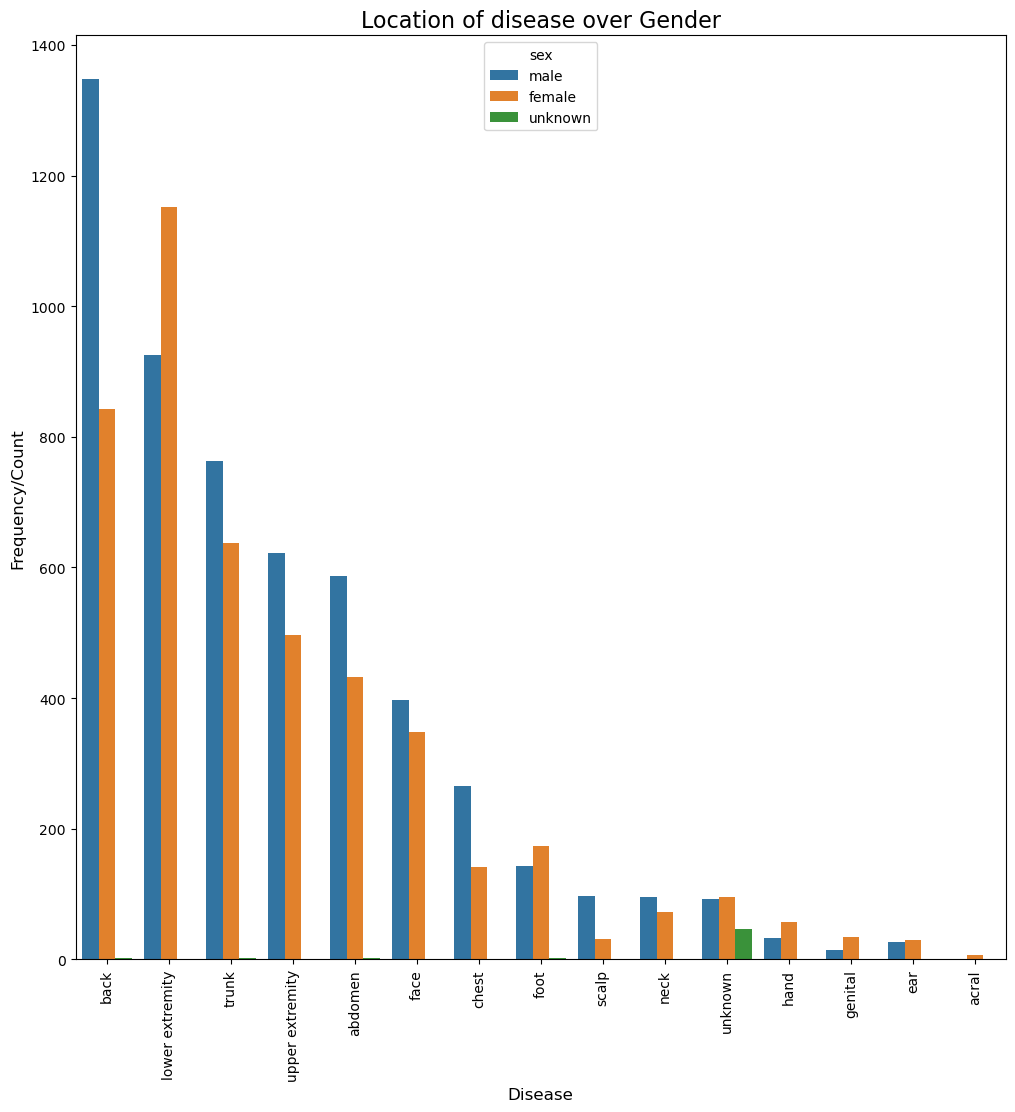

In [31]:
print("Location of disease over Gender")
"""Location of disease over Gender"""

value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

### Oversampling

###### To overcome class imbalace

In [17]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [18]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [19]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

# Model Training

In [20]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [21]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 1.2004 - accuracy: 0.5327
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 52s 197ms/step - loss: 1.2004 - accuracy: 0.5327 - val_loss: 0.8390 - val_accuracy: 0.6908
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.7432
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 48s 204ms/step - loss: 0.7004 - accuracy: 0.7432 - val_loss: 0.5397 - val_accuracy: 0.8072
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8410
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 44s 189ms/step - loss: 0.4491 - accuracy: 0.8410 - val_loss: 0.4374 - val_accuracy: 0.8481
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8936
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 44s 185ms/step 

# Plot Accuracy and Loss

### Accuracy (training vs validation dataset)

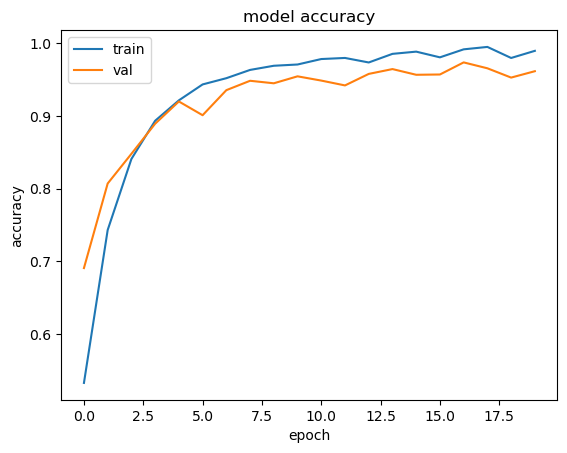

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Loss (training vs validation dataset)

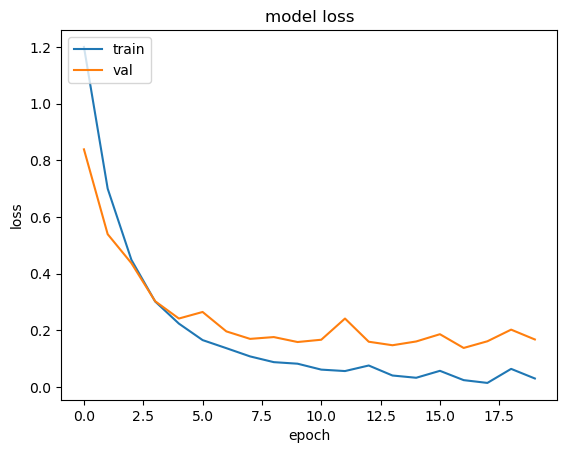

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model Testing

In [25]:
model.load_weights('best_model.h5')

In [26]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 5s - loss: 0.1608 - accuracy: 0.9646 - 5s/epoch - 18ms/step


# Model Evaluation

In [28]:
print('train_accuracy : ',max(history.history['accuracy'])*100)
print('val_accuracy : ',max(history.history['val_accuracy'])*100)
print('test_accuracy : ',acc*100)
print("--------------------------------------")
print('train_loss : ',max(history.history['loss'])*100)
print('val_loss : ',max(history.history['val_loss'])*100)
print('test_loss : ',loss*100)

train_accuracy :  99.52060580253601
val_accuracy :  97.39014506340027
test_accuracy :  96.46319150924683
--------------------------------------
train_loss :  120.04350423812866
val_loss :  83.90434980392456
test_loss :  16.08116775751114
